<a href="https://colab.research.google.com/github/rokmc3852/study/blob/master/EDA_To_Prediction_mine_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# @title 실행

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T113102Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D71d5e08ee7a4ebe1d1b8d4bd3fa73edd603a6bf4f1d6c0c148bc93e3194966ff0584772deda57ae4c6a9e8748737defa5359d3ce2d8a65fdeb49e2b66385fa8a6884ecc7f45ef0c143c7d92e4e1e0d833513ac6f905c34dbdf0d35ce94e65d81b5cab3383bafa895a2ca1fd1ed98467f64bd425e3fcb005254f4f052bd63935aaed51af920e131df5a06498ecb2afd6472ff776ea10e45e84aa37442690d79e9c90ebb905b1ec60a2d9b381f71248e9dbed6e2f458ddd3f4ad43398c83c739f988b812c943df75e50e40509bd3c1d564ef418c90eaebdb5f71779cd8745dc10ca45e7b256d8931e2b26a2eeffcf02b15be85ea9d5dac8845adaf989c61c3a5b1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# EDA To Prediction


### Part1: 탐색적 데이터 분석(EDA)
1) 특징 분석.
2) 여러 특징을 고려하여 관계나 경향 찾기.

### Part2: 특징 엔지니어링 및 데이터 정리
1) 몇 가지 새로운 특징 추가.
2) 중복된 특징 제거.
3) 모델링에 적합한 형태로 특징 변환.

### Part3: 예측 모델링
1) 기본 알고리즘 실행.
2) 교차 검증.
3) 앙상블.
4) 중요한 특징 추출.

## Part1: Exploratory Data Analysis(EDA)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [28]:
data=pd.read_csv('../input/train.csv')

In [29]:
data ## sibsp 함께 탑승한 형제자매 배우자/ parch 함께탑승한 부모 자녀 수 / Fare 티켓 가격 / cabin 객실넘버 / embarked 탑승항구


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [30]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
data.shape

(891, 12)

In [32]:
data.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
data.isnull().sum() #checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

나이(Age), 객실(Cabin) 및 탑승지(Embarked)에 누락된 값이 있습니다. 이를 수정하려고 합니다.

### train 데이터에서 몇명이나 살아남앗는지 확인

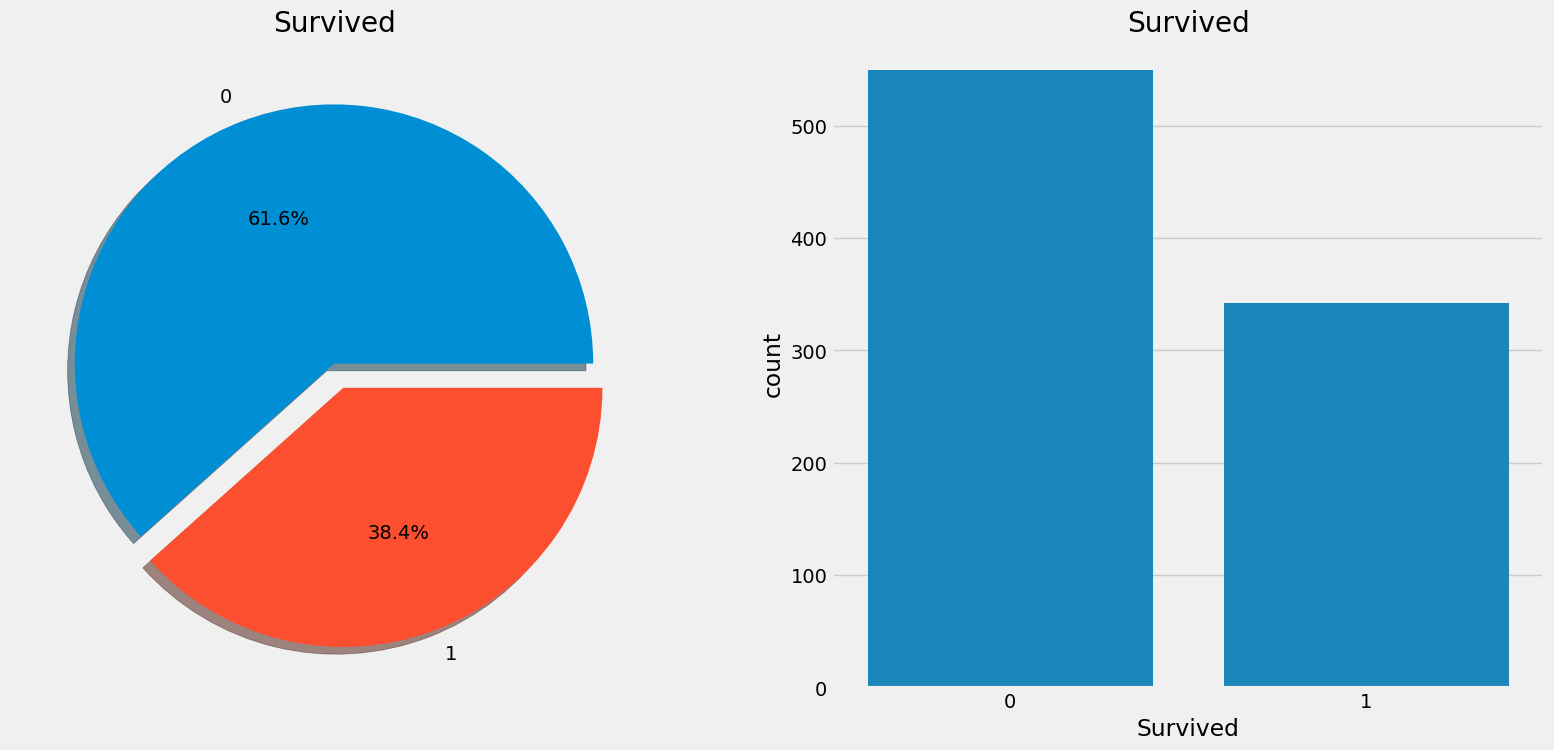

In [34]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x='Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

In [35]:
data.groupby('Survived').Survived.count() ## 질문

Survived
0    549
1    342
Name: Survived, dtype: int64

많은 승객들이 사고에서 살아남지 못했다는 것이 명백합니다.

훈련 세트에 있는 891명의 승객 중 약 350명만이 생존했으며, 즉 전체 훈련 세트의 **38.4%**만이 침몰 사고에서 살아남았습니다. 데이터를 더 깊이 분석하여 더 나은 인사이트를 얻고, 어떤 범주의 승객이 생존했는지, 누가 생존하지 못했는지 알아볼 필요가 있습니다.

데이터셋의 다양한 특징을 사용하여 생존율을 확인해보겠습니다. 일부 특징으로는 성별, 탑승 항구, 나이 등이 있습니다.

먼저, 다양한 종류의 특징을 이해해 보겠습니다.

## 특징의 종류

### 범주형 특징:
범주형 변수는 두 개 이상의 범주를 가지며, 그 특징의 각 값은 해당 범주로 분류될 수 있습니다. 예를 들어, 성별은 두 개의 범주(남성 및 여성)를 가지는 범주형 변수입니다. 이러한 변수는 정렬하거나 순서를 매길 수 없습니다. 이러한 변수는 **명목 변수**라고도 합니다.

**데이터셋의 범주형 특징: 성별(Sex), 탑승지(Embarked)**

### 순서형 특징:
순서형 변수는 범주형 값과 유사하지만, 차이점은 값들 사이에 상대적인 순서나 정렬이 가능하다는 것입니다. 예를 들어, **키(Height)**라는 특징이 **크다(Tall), 중간(Medium), 작다(Short)**와 같은 값을 가진다면, 키는 순서형 변수입니다. 여기서 변수 간에 상대적인 정렬이 가능합니다.

**데이터셋의 순서형 특징: PClass(객실 등급)**

### 연속형 특징:
특징이 두 점 사이 또는 특징 열의 최소값과 최대값 사이의 값을 가질 수 있다면, 그 특징은 연속형이라고 합니다.

**데이터셋의 연속형 특징: 나이(Age)**

## 특징 분석

## 성별 -> 범주형




In [36]:
data.groupby('Sex').Sex.count()

Sex
female    314
male      577
Name: Sex, dtype: int64

In [37]:
data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [38]:
data.groupby(['Sex','Survived']).Survived.count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

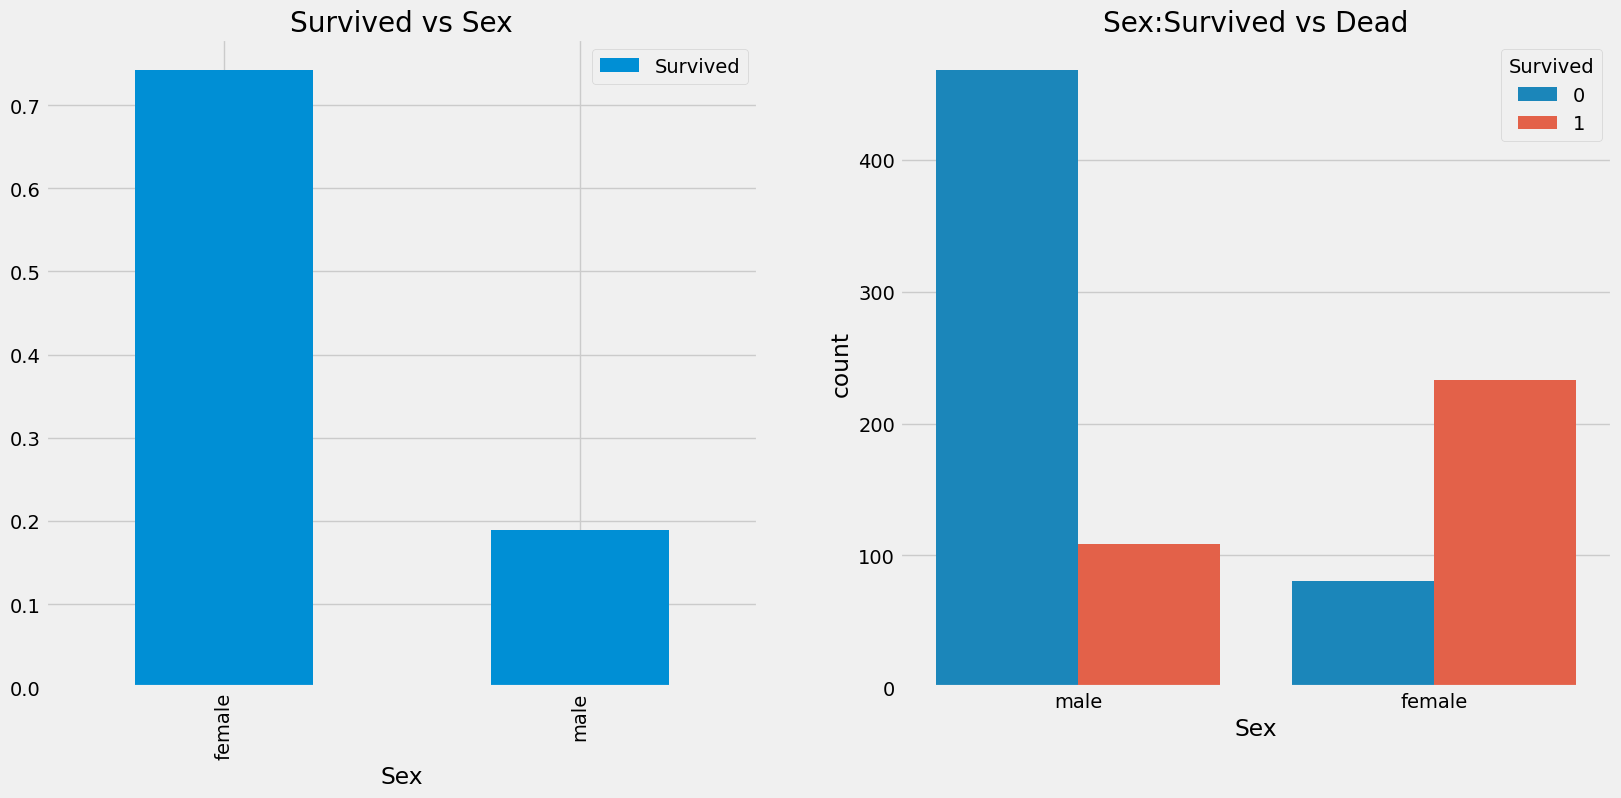

In [39]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

성별에 따른 생존여부에 대해서 시각화를 통해 분석해보았습니다.
배에 탑승한 남성의 수가 여성의 수보다 훨씬 많습니다. 그럼에도 불구하고 구조된 여성의 수는 구조된 남성의 수의 거의 두 배입니다. 배에 탑승한 여성의 생존율은 약 75%인 반면, 남성의 생존율은 약 18-19%입니다.

**성별**이라는 특징은 모델링에 있어 매우 중요한 특징으로 보입니다.

하지만 이것이 가장 중요한 특징일까요? 다른 특징들도 확인해 봅시다.

## 객실등급 -> 순서형 특징

In [40]:
pd.crosstab(data.Pclass,data.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


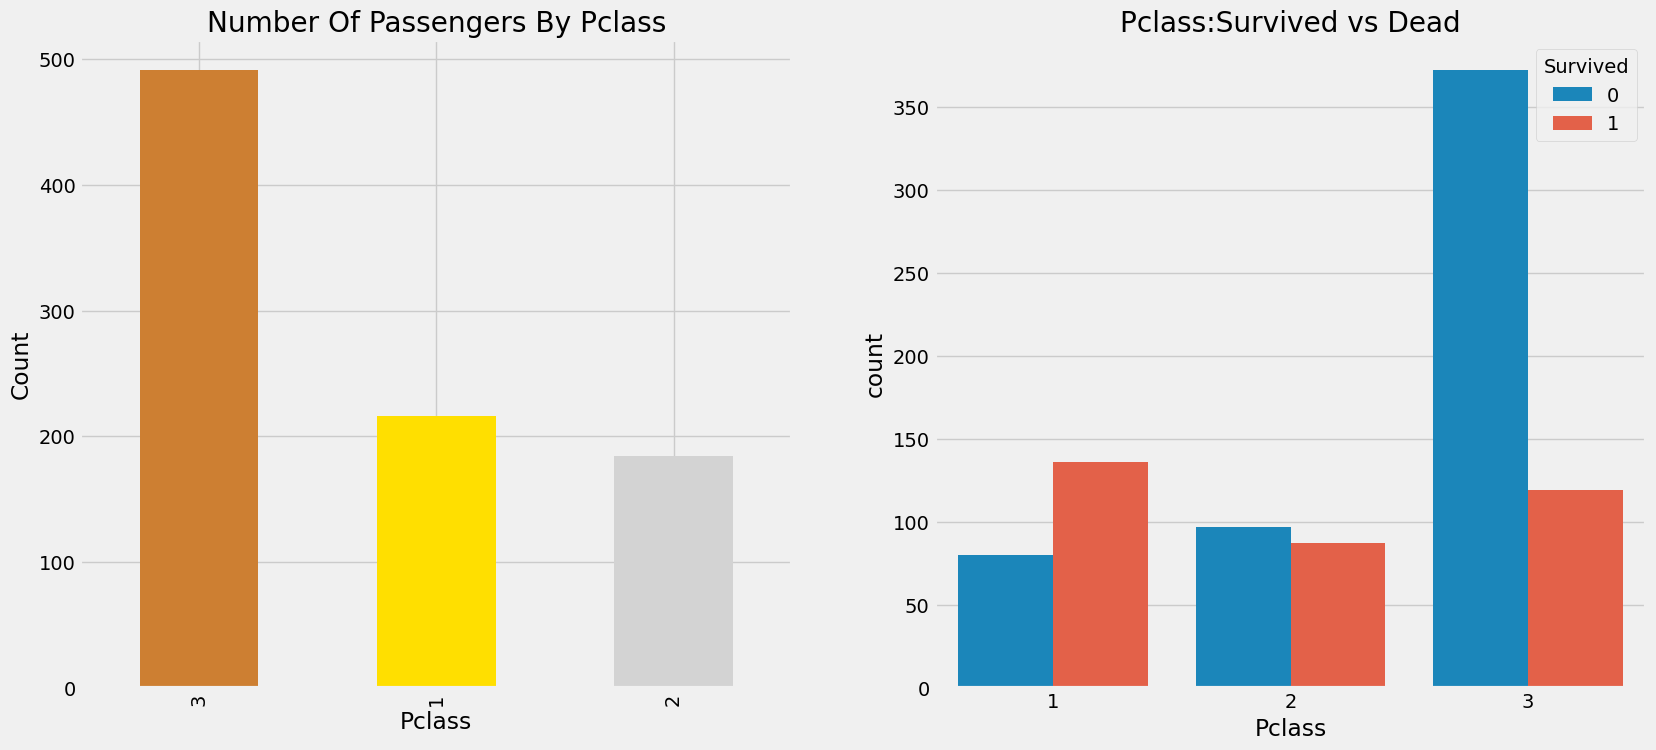

In [41]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

각 객실등급에 따라서 생존율이 달라진다는 것을 확인했습니다.
일등석 승객 수는 삼등급보다 훨씬 많았지만, 그들 중 생존한 사람들의 수는 매우 적습니다. 대략 **25%** 정도입니다.

일등석의 생존율은 **63%** 정도이고, 이등석의 생존율은 **48%** 정도입니다.

좀 더 자세히 살펴보고 흥미로운 관찰을 해보겠습니다. **성별과 객실 등급(Pclass)**에 따른 생존율을 함께 확인해 봅시다.

In [42]:
pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True).style.background_gradient(cmap='summer_r')

1등석 여성 96% 생존

2등석 여성 92% 생존

3등석 여성 50% 생존

1등석 남성 36% 생존

2등석 남성 15% 생존

3등석 남성 13% 생존

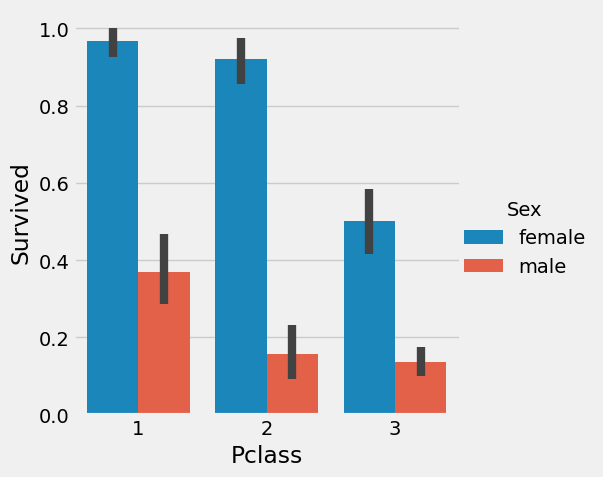

In [43]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='bar', data=data)
plt.show()

Pclass1의 여성의 생존율이 약 **95-96%**임을 쉽게 추론할 수 있습니다. 왜냐하면 Pclass1에서 94명의 여성 중 3명만이 사망했기 때문입니다.

구조 과정에서 Pclass와 관계없이 여성들이 우선적으로 구조를 받았다는 것이 명백합니다. 심지어 일등석에 있는 남성들도 생존율이 매우 낮습니다.

Pclass도 중요한 특징인 것으로 추정됩니다

## 나이 -> 연속형 특징


177명 데이터 누락(결측치) - > 대략 20%

In [44]:
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years') ## 1년을 12개월로 나누면.. 5개월 정도
print('Average Age on the ship:',data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


<Axes: xlabel='Age', ylabel='Density'>

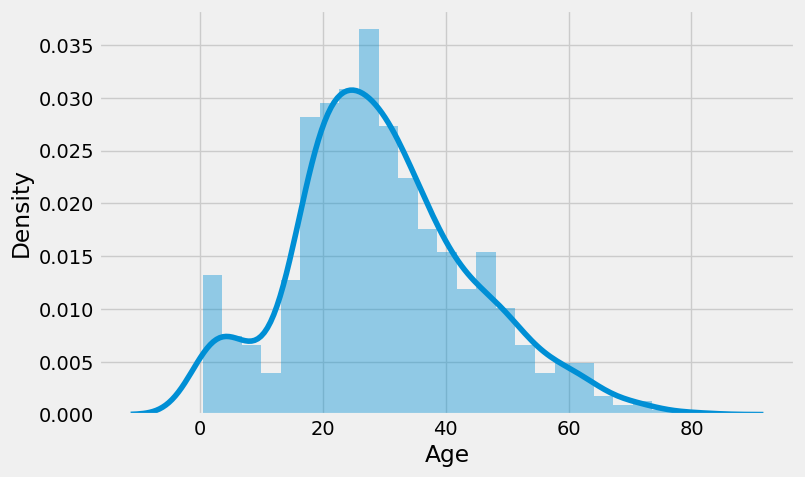

In [45]:
plt.figure(figsize=(8, 5))
sns.distplot(data['Age'], bins=25)

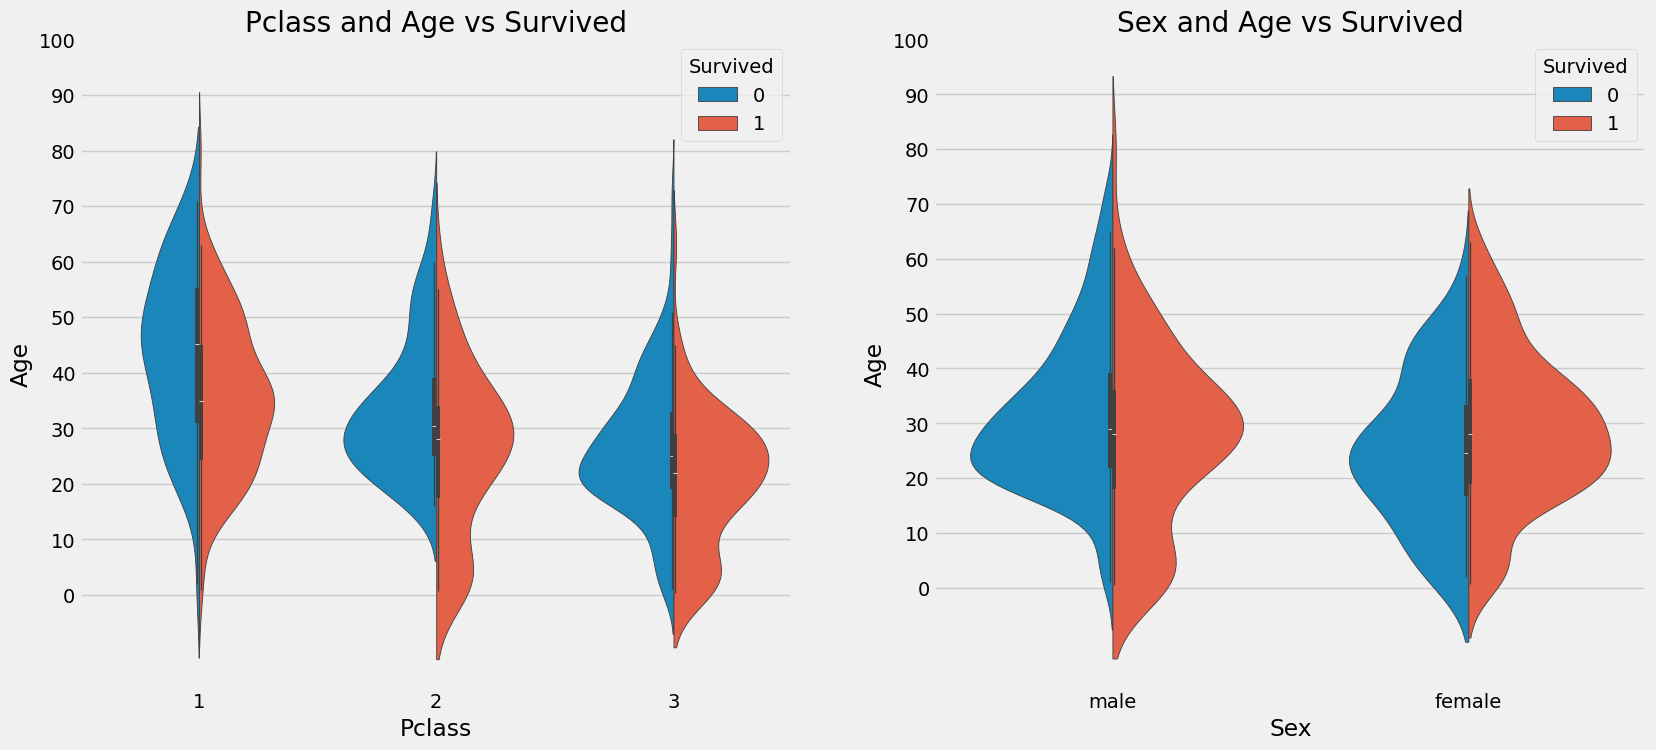

In [46]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot(x="Pclass",y="Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

#### 분석결과

1) 어린이의 수는 Pclass와 함께 증가하며, 10세 미만의 승객(즉, 어린이)의 생존율은 Pclass에 관계없이 좋아 보입니다.

2) 20-50세의 일등석 승객의 생존 가능성이 높으며, 여성의 경우 더욱 좋습니다.

3) 남성의 경우, 나이가 증가함에 따라 생존 가능성이 감소합니다.

앞에서 확인했듯이, 나이 특징에는 **177**개의 결측치 값이 있습니다. 이러한 NaN 값을 대체하기 위해 데이터셋의 평균 연령을 할당할 수 있습니다.

그러나 문제는 많은 다양한 연령대의 사람들이 있었습니다. 우리는 29세인 평균 연령을 4살 어린이에게 할당할 수 없습니다. 승객이 어느 연령대에 속하는지 어떻게 알 수 있을까요?


우리는 **이름(Name)** 특징을 확인할 수 있습니다. 이 특징을 살펴보면 이름에 Mr 또는 Mrs와 같은 칭호가 있는 것을 볼 수 있습니다. 따라서 Mr와 Mrs의 평균 값을 각 그룹에 할당할 수 있습니다.

**"이름에 무엇이 있을까요?"**---> **특징**  :

In [47]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [48]:
pd.crosstab(data.Initial,data.Sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


일부 오타가 있는 성씨가 있습니다. 예를 들어, Mlle 또는 Mme는 Miss를 나타냅니다. 이들을 Miss로 대체할 것입니다. 다른 값들에 대해서도 동일한 작업을 수행할 것입니다.

In [49]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [50]:
data.groupby('Initial')['Age'].mean() #lets check the average age by Initials

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

### Filling NaN Ages

In [51]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [52]:
data.Age.isnull().any() #So no null values left finally

False

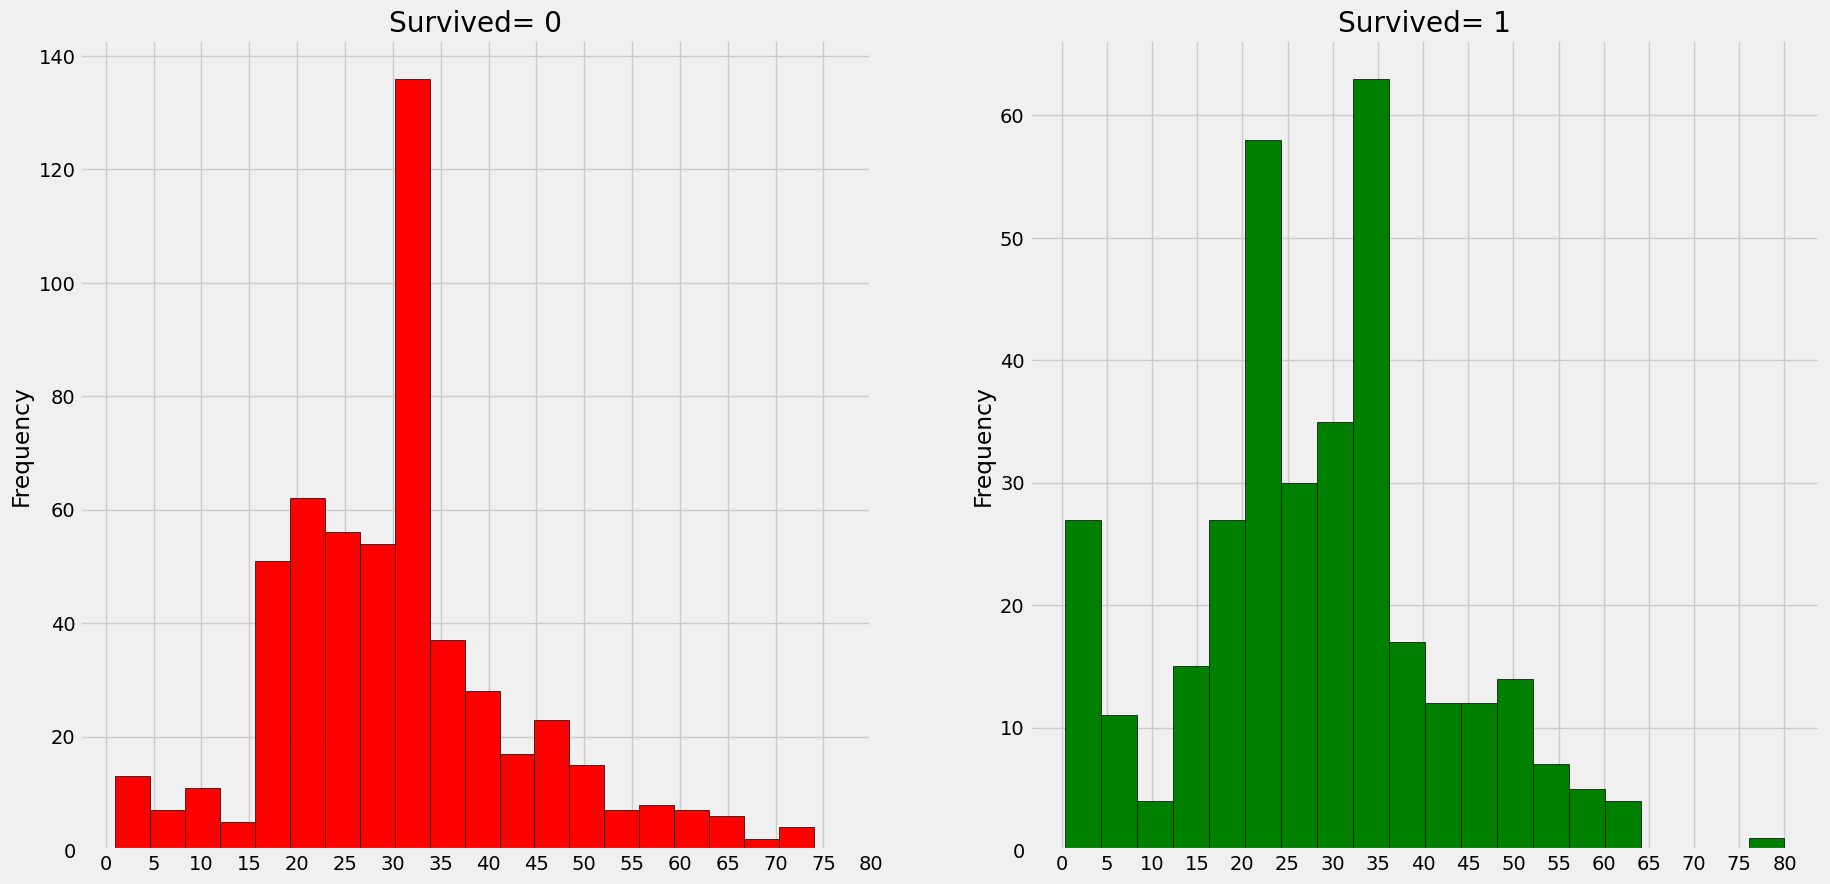

In [53]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

### 분석
유아들(나이<5)은 대거로 구조되었습니다(여성과 어린이 우선 정책).

가장 나이 많은 승객(80세)이 구조되었습니다.

가장 많은 사망자는 30-40세 연령대에 있었습니다.

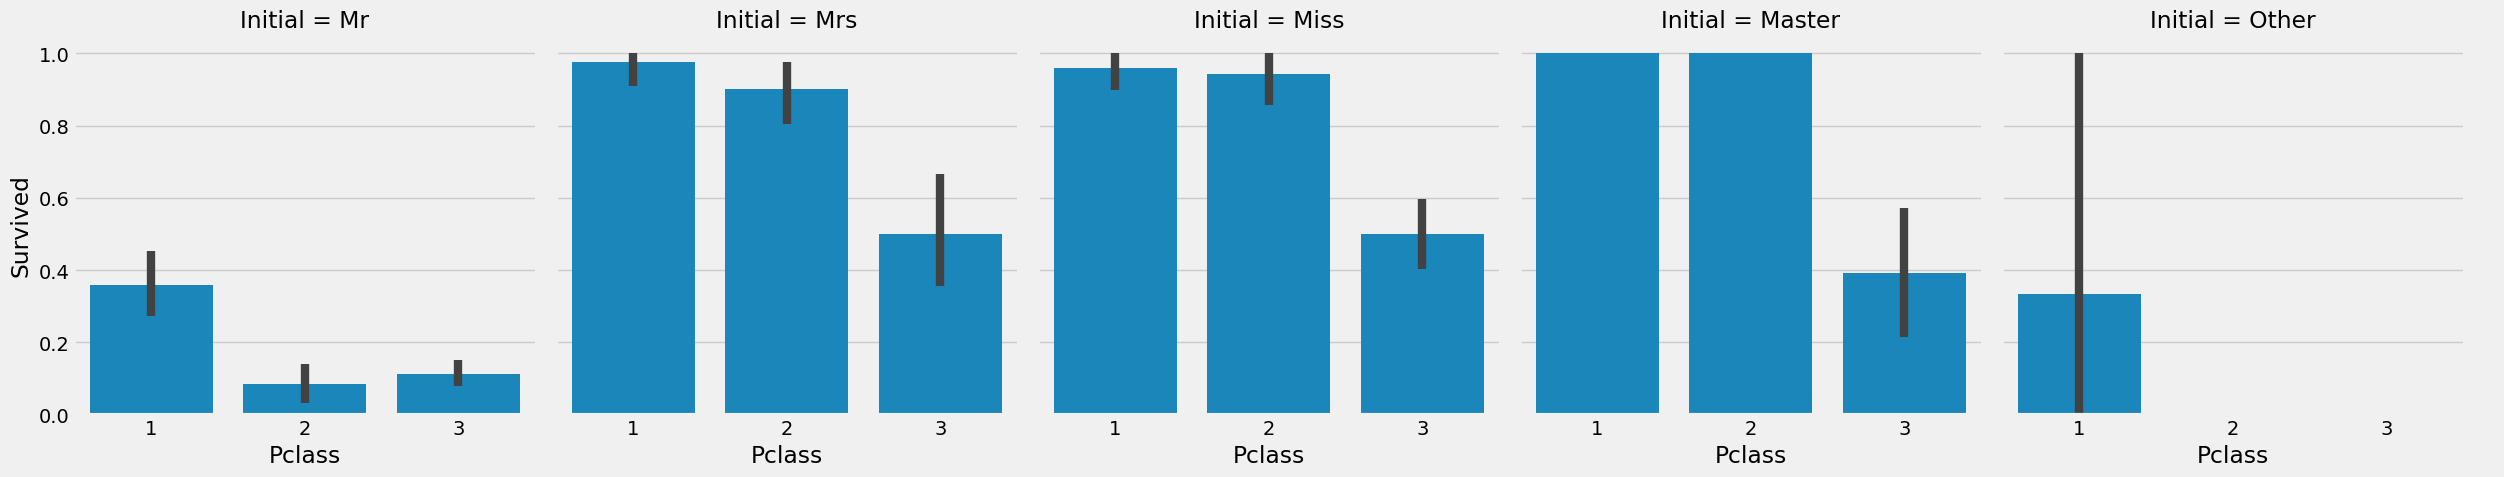

In [54]:
sns.catplot(x='Pclass', y='Survived', col='Initial', kind='bar', data=data)
plt.show()

여성과 어린이 우선 정책은 클래스와 관계없이 참된다는 것을 의미합니다.

## 탑승지 -> 범주형 값

In [55]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True).style.background_gradient(cmap='summer_r')

### 탑승 항구별 생존 가능성에 대해서 분석해보자

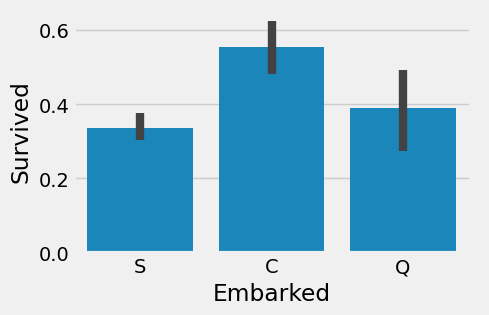

In [56]:
sns.catplot(x='Embarked',y='Survived' ,kind='bar',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

C 항구의 생존 가능성이 약 0.55로 가장 높지만, S 항구의 경우 가장 낮습니다.

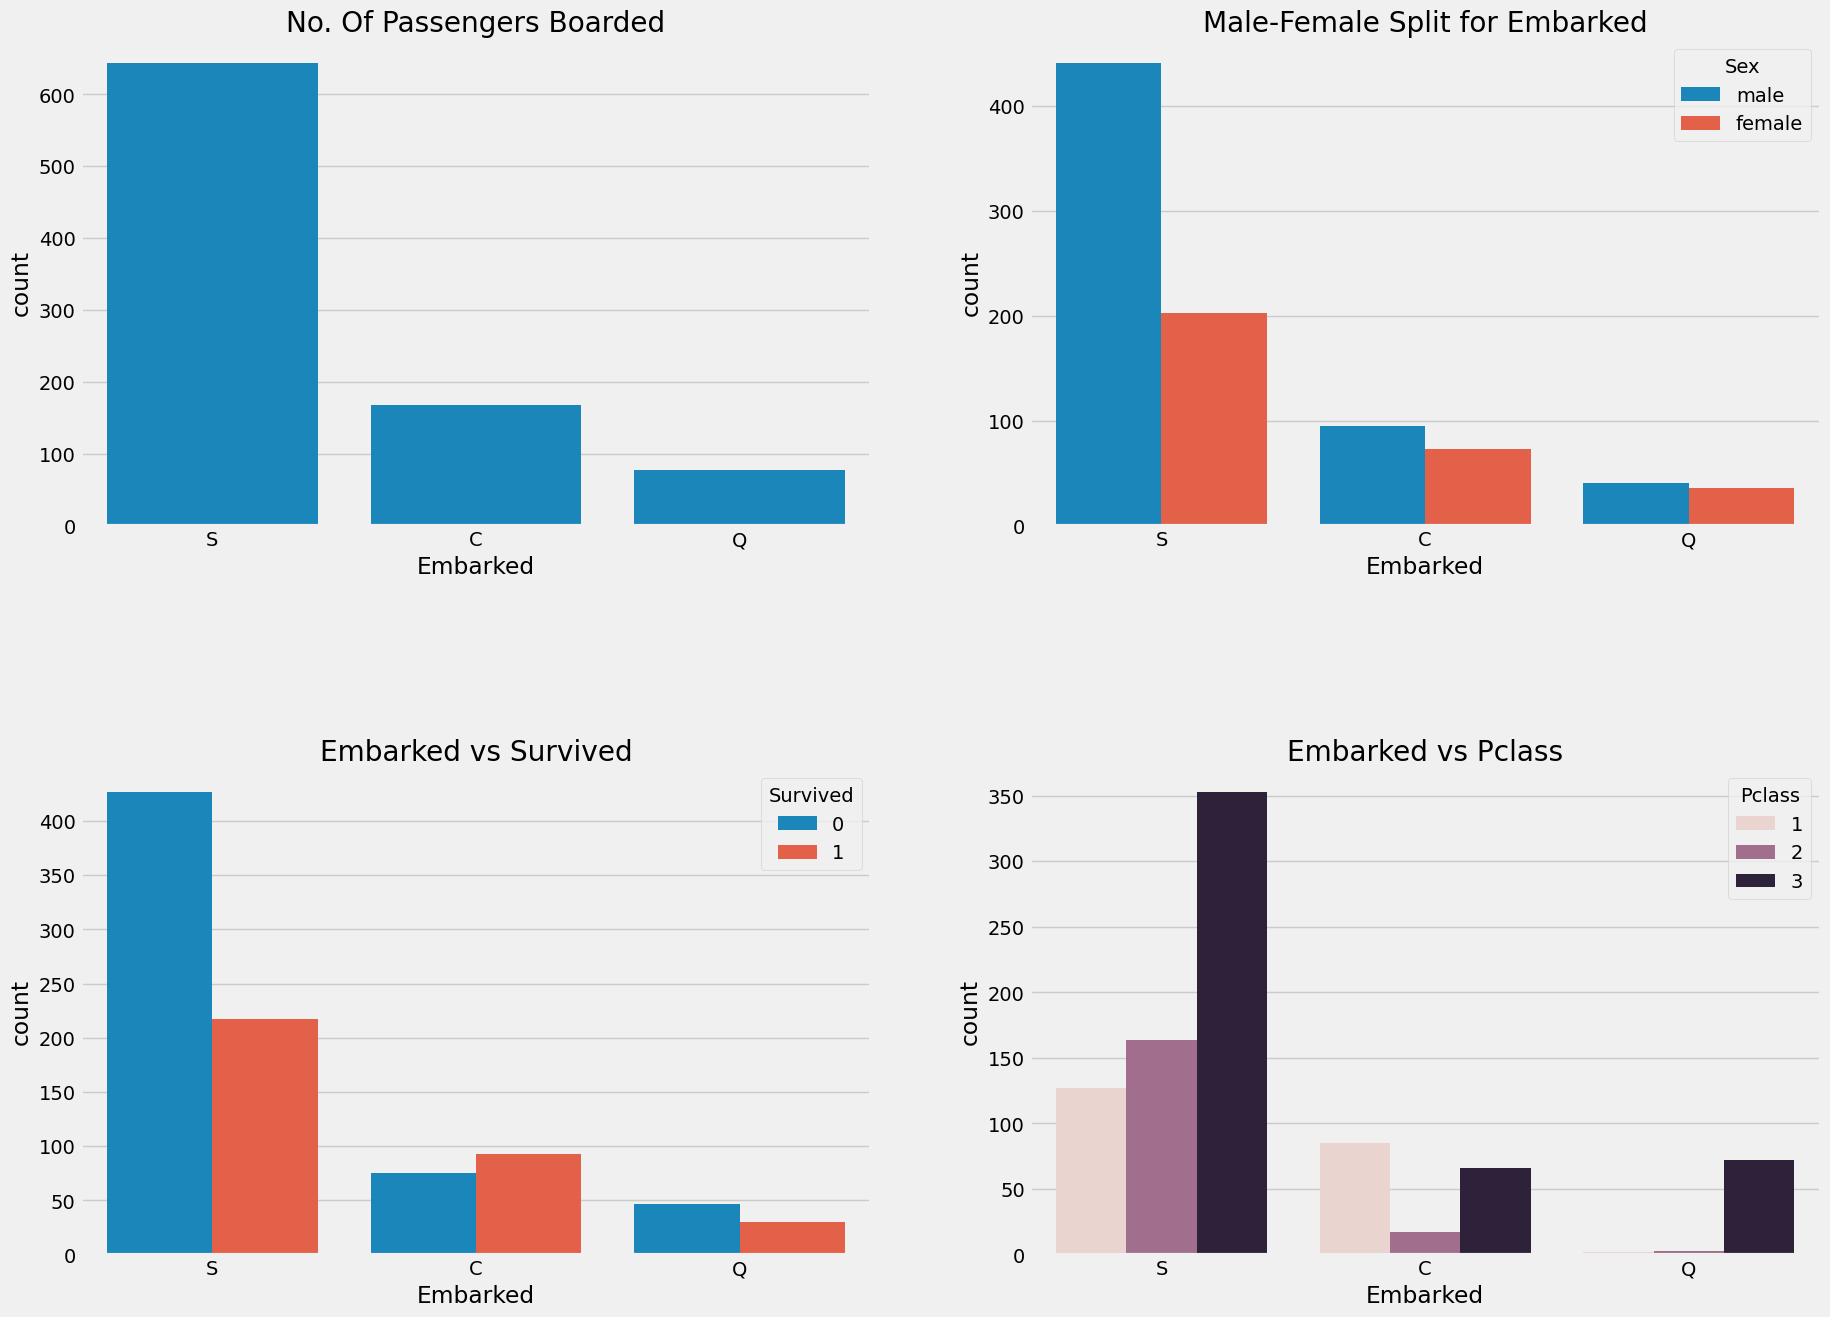

In [57]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot(x='Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot(x='Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot(x='Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot(x='Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

### 데이터 분석
1) S에서 탑승한 승객이 가장 많습니다. 그 중 대부분은 Pclass3 출신입니다.

2) C에서 탑승한 승객들은 상당 수가 생존한 것으로 보입니다. 이것의 이유는 아마도 Pclass1과 Pclass2 승객 전부가 구조된 것일 수 있습니다.

3) 탑승 항구 S는 대다수의 부자들이 탑승한 항구로 보입니다. 그럼에도 불구하고 여기서의 생존 가능성은 낮습니다. 이는 Pclass3에서 많은 승객(약 **81%**)이 생존하지 못했기 때문입니다.

4) Q 항구는 거의 95%의 승객이 Pclass3 출신이었습니다.

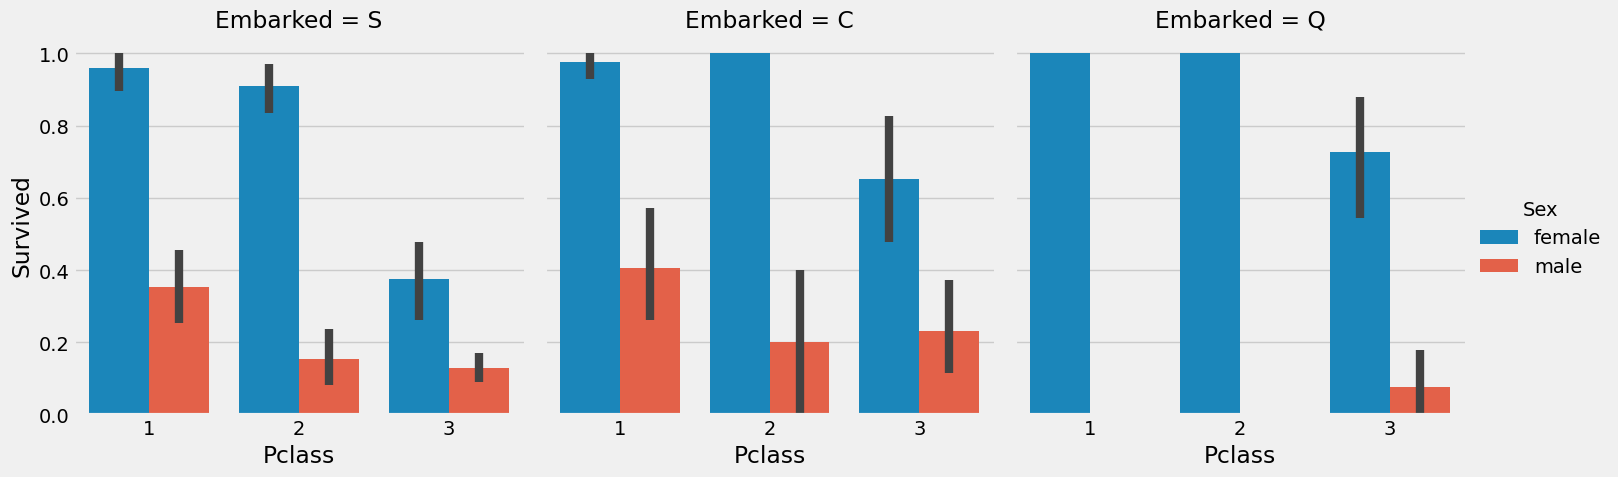

In [58]:
sns.catplot(x='Pclass',y='Survived',hue='Sex',col='Embarked',kind='bar',data=data)
plt.show()

### 데이터 분석

1) Pclass와 관계없이 일등석과 이등석의 여성들의 생존 가능성은 거의 1에 가깝습니다.

2) Pclass3 승객들에게는 항구 S가 매우 불운한 곳으로 보입니다. 남성과 여성 모두 생존율이 매우 낮습니다. (**돈이 중요합니다**)

3) 항구 Q는 남성들에게 가장 불운한 곳으로 보입니다. 거의 모든 남성이 Pclass 3 출신이었습니다.

### 탑승 항구 결측치 값 채우기

우리가 보았듯이 가장 많은 승객이 항구 S에서 탑승했으므로, 결측치 값을 S로 대체합니다.

사실 결측치를 처리하는 방법은 매우 다양

모든 방법에 대해서 학습하기에는 시간이 부족해서..

결측치를 처리하는 대표적인 방법 중 하나인 최빈값(데이터에서 가장 많이 관찰된 값)으로 대체하는 방법을 사용함

In [59]:
data['Embarked'].fillna('S',inplace=True)

In [60]:
data.Embarked.isnull().any()# Finally No NaN values

False

## 형제자매 및 배우자 -> 수치형 중 이산형 특징
이 특징은 사람이 혼자 있는지 아니면 가족 구성원과 함께 있는지를 나타냅니다.

형제자매 = 형제, 자매, 이복 형제, 이복 자매

배우자 = 남편, 아내

In [61]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


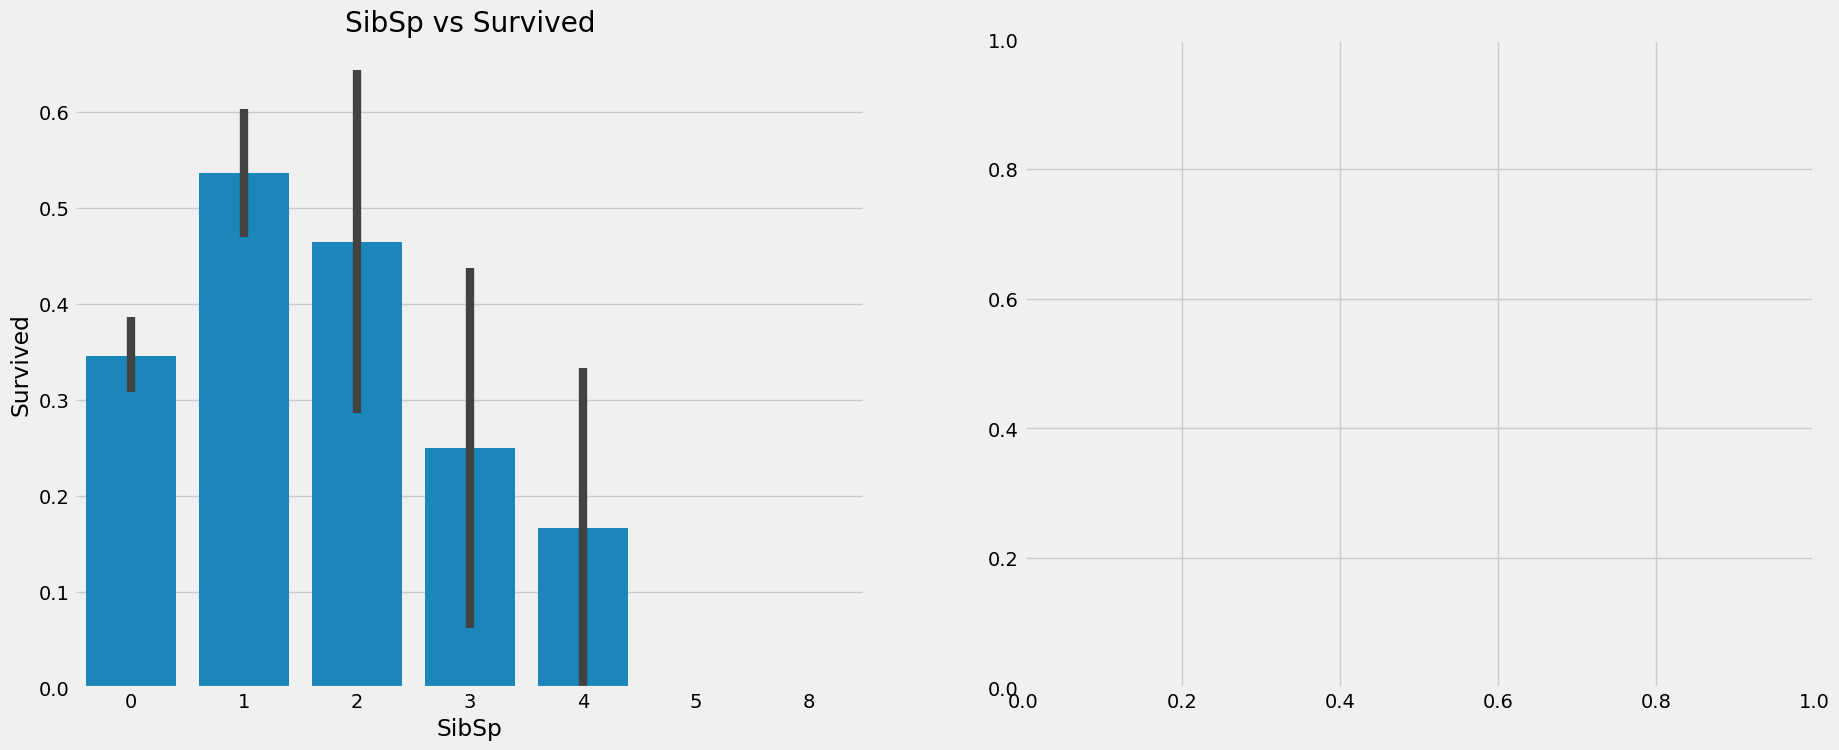

In [62]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot(x='SibSp',y='Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
plt.show()

In [63]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


### 데이터 분석

혼자 승선하고 형제가 없는 승객의 경우 생존율이 34.5%인 것을 보여줍니다. 형제 자매의 수가 증가할수록 생존율이 대략적으로 감소하는 것으로 나타납니다. 이는 합리적입니다. 즉, 가족이 함께 승선한다면 나 자신을 구하는 대신 가족을 구하려고 할 것입니다. 놀랍게도, 5-8명 가족 구성원의 생존율은 **0%**입니다. 그 이유는 Pclass 때문인가요??

그 이유는 **Pclass**입니다. crosstab은 SibSp>3인 사람들이 모두 Pclass3에 있었음을 보여줍니다. Pclass3의 대가족은 모두(>3) 사망했습니다.

## 탑승객이 부모나 자녀와 함께 승선하였는 나타내는 특성 - parch

In [64]:
pd.crosstab(data.Parch,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


교차표는 다시 한 번 대가족이 Pclass3에 있었음을 보여줍니다.

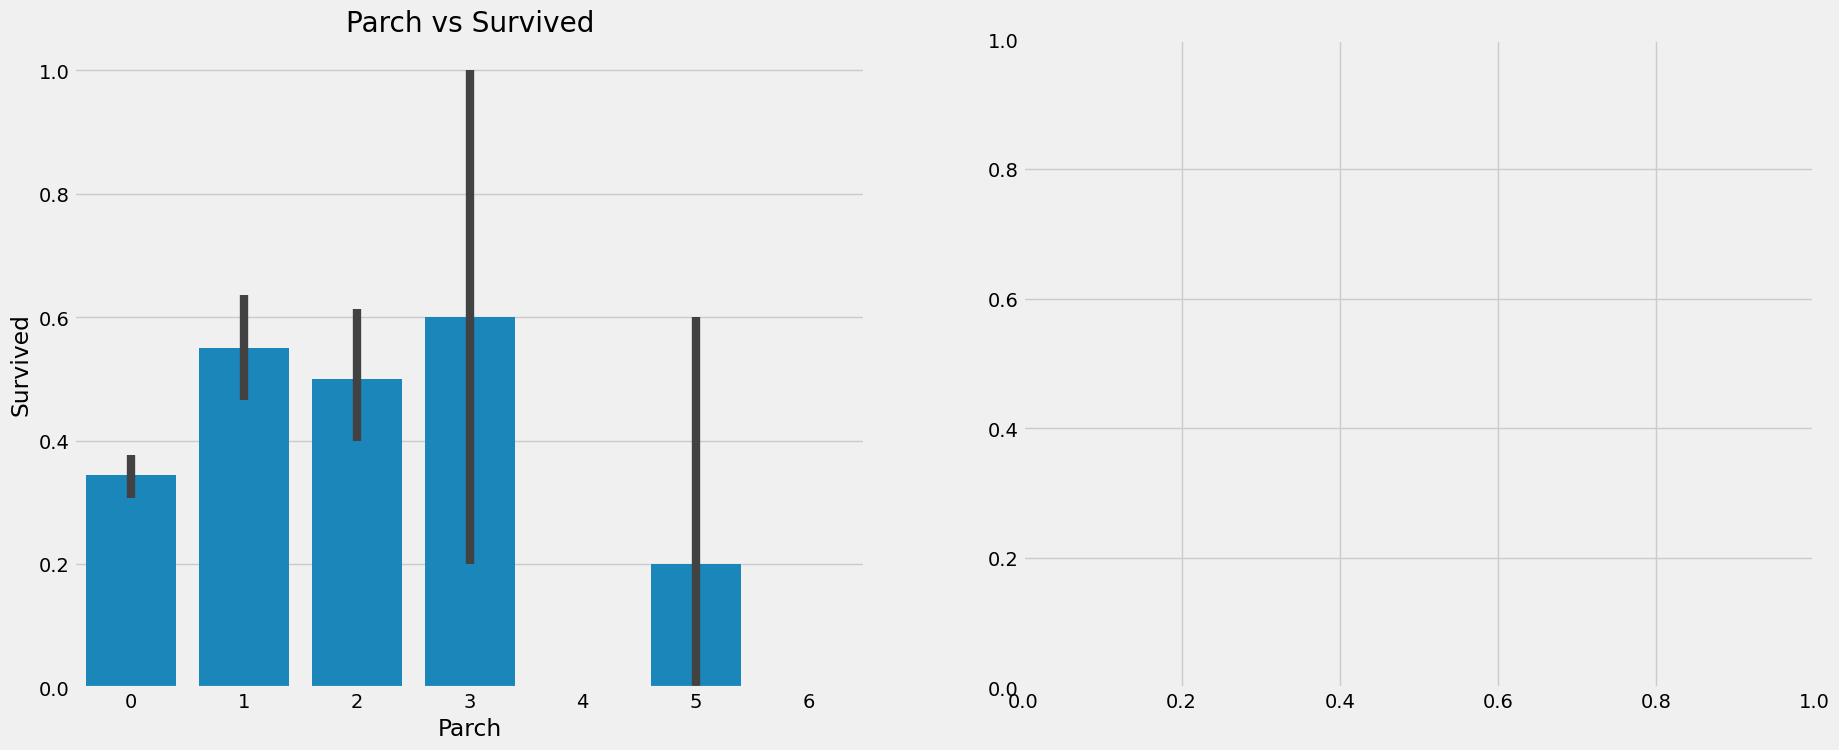

In [65]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot(x='Parch',y='Survived',data=data,ax=ax[0])
ax[0].set_title('Parch vs Survived')
plt.show()

### 데이터 분석

여기서도 결과는 매우 유사합니다. 부모와 함께 탑승한 승객은 생존할 확률이 더 높습니다. 그러나 부모혹은 가족의 수가 증가함에 따라 생존율이 감소합니다.

선박에 1-3명의 부모가 있는 사람의 생존 가능성이 높습니다. 혼자인 것도 치명적이며, 누군가가 선박에 4명 이상의 부모혹은 가족가 있는 경우 생존 가능성이 감소합니다.

## 승객이 지불한 운임비 -> 연속형 특징

In [66]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


돈을 내지 않고 탑승한 고객도 있음...

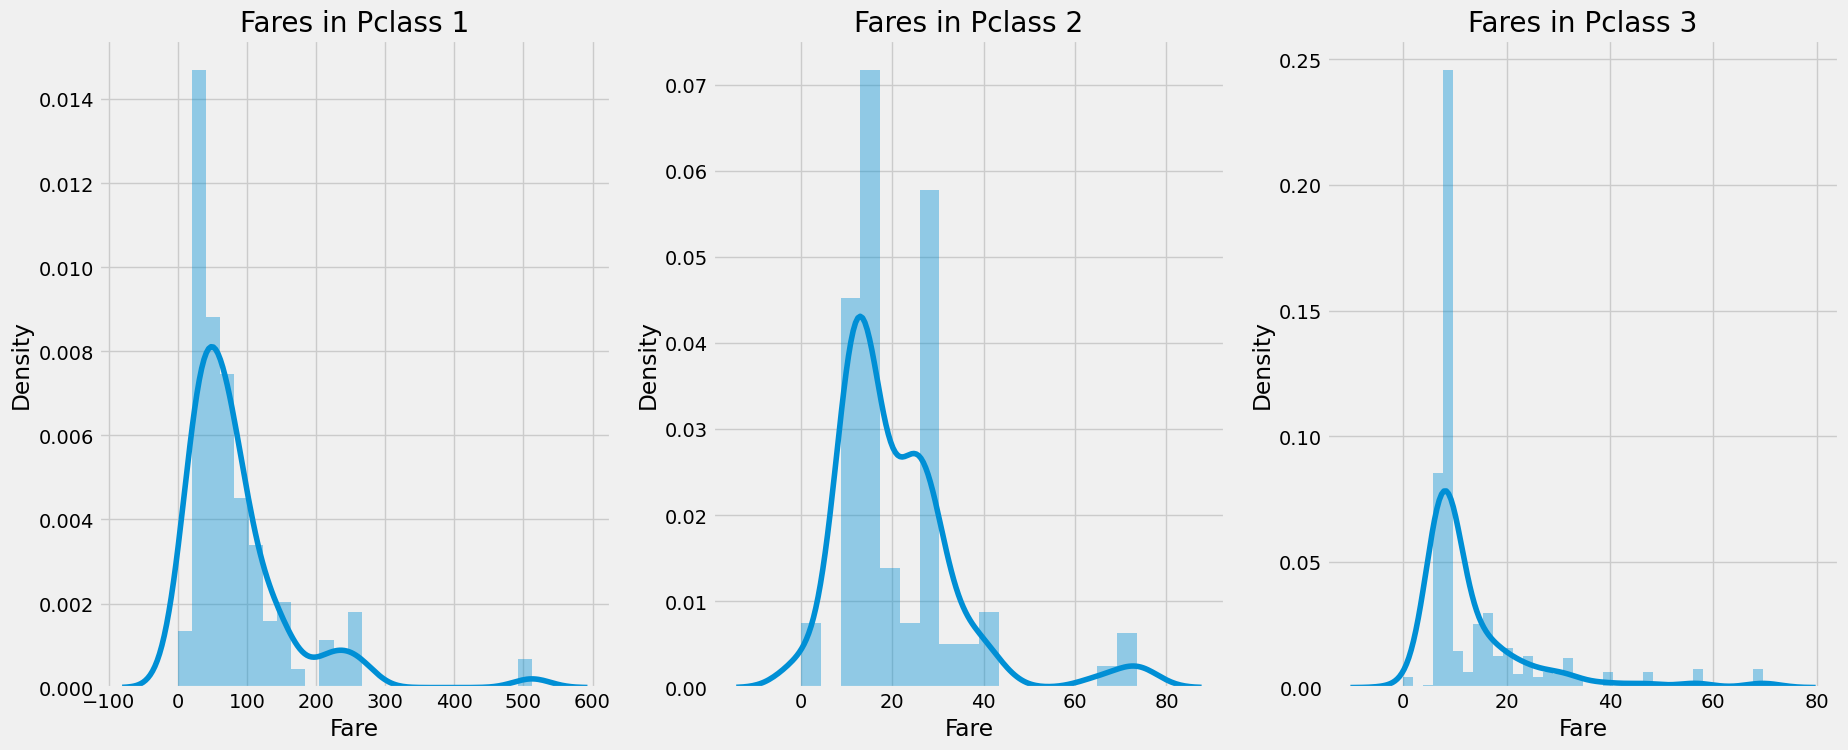

In [67]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

일등석 승객의 요금은 분포가 크게 나타나며, 이 분포는 등급이 낮아질수록 감소합니다.
이 또한 연속형이므로, 우리는 특정 구간을 같은 값으로 묵어 이를 이산형 값으로 변환할 수 있습니다.

### 정리!

**성별:** 여성의 생존 확률이 남성에 비해 높습니다.

**선실 등급:** 1등석 승객일수록 생존 확률이 높은 경향이 있습니다. 3등석 승객의 생존률은 매우 낮습니다. 여성의 경우, 1등석 승객의 생존 확률은 거의 1에 가깝고 2등석 승객의 경우도 높습니다. **돈이 이기는 것 같네요!**

**나이:** 5-10세 미만의 어린이들은 생존 확률이 높습니다. 15세에서 35세 사이의 승객들이 많이 사망했습니다.

**탑승 항구:** 이는 매우 흥미로운 특징입니다. **C에서의 생존 확률이 S보다 더 나은 것으로 보입니다.** 하지만 대부분의 1등석 승객이 S에서 탑승했습니다. Q에서의 승객은 모두 3등석이었습니다.

**부모와 자녀, 형제자매:** 1-2명의 형제자매나 배우자가 함께 탑승하거나 1-3명의 부모가 함께하는 것이 혼자이거나 대가족과 함께하는 것보다 생존 확률이 높은 것으로 나타납니다.



## Correlation Between The Features

In [68]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


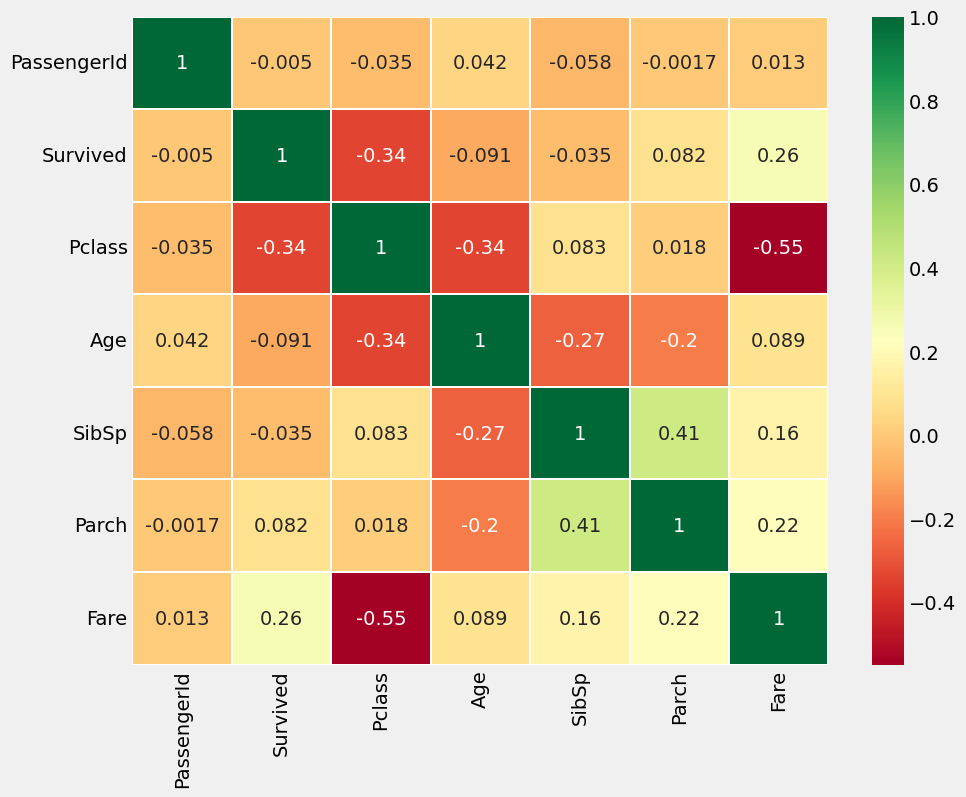

In [69]:
sns.heatmap(data.drop(columns=['Name', 'Sex', 'Ticket','Cabin','Embarked','Initial']).corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### 히트맵 해석

가장 먼저 주목할 점은 숫자형 특성만 비교된다는 것입니다. 알파벳이나 문자열 사이에 상관 관계를 분석할 수 없기 때문에 당연한 일입니다. 플롯을 이해하기 전에 상관 관계가 정확히 무엇인지 살펴봅시다.

**양의 상관 관계:** 특성 A의 증가가 특성 B의 증가로 이어지면, 그들은 양의 상관 관계를 가집니다. 값 **1은 완벽한 양의 상관 관계**를 의미합니다.

**음의 상관 관계:** 특성 A의 증가가 특성 B의 감소로 이어지면, 그들은 음의 상관 관계를 가집니다. 값 **-1은 완벽한 음의 상관 관계**를 의미합니다.

이제 두 특성이 높거나 완전히 상관 관계가 있는 경우, 한 특성의 증가가 다른 특성의 증가로 이어집니다. 이는 두 특성이 거의 동일한 정보를 포함하고 있으며 정보의 분산이 거의 없거나 없음을 의미합니다. 이를 **다중공선성**이라고 하며, 두 특성 중 하나가 중복되므로 불필요한 것입니다. 모델을 만들거나 훈련할 때 불필요한 기능을 제거하려고 노력해야 합니다. 이는 훈련 시간을 줄이고 많은 이점을 가져다줍니다.

이제 위의 히트맵에서 특성들이 크게 상관되어 있지 않음을 알 수 있습니다. 가장 높은 상관 관계는 **SibSp와 Parch 간의 상관 관계, 즉 0.41**입니다. 따라서 모든 특성을 유지하는 것이 좋습니다.

## Part2: Feature Engineering and Data Cleaning


그렇다면 feature engineering이란 무엇일까요?

우리에게 특성이 있는 데이터셋이 주어지면, 모든 특성이 중요할 필요는 없습니다. 많은 중복된 특성이 있을 수 있으며 이를 제거해야 합니다. 또한 다른 특성에서 관찰하거나 추출된 정보를 사용하여 새로운 특성을 얻거나 추가할 수 있습니다.

예를 들어, 이름 특성을 사용하여 이니셜 특성을 얻는 것입니다. 새로운 특성을 얻을 수 있는지 확인하고 몇 개의 특성을 제거해 보겠습니다. 또한 예측 모델링에 적합한 형식으로 기존의 관련 특성을 변환할 것입니다.

## 나이 특징을 범위로 변형!

#### 나이 특성의 문제점:
이전에 언급했듯이 **나이는 연속적인 특성**이며, 머신러닝 모델에서 연속 변수의 문제점이 있습니다.

**예:** 만약 **성별**로 스포츠 선수를 그룹화하거나 정렬하라고 하면, 우리는 쉽게 남성과 여성으로 나눌 수 있습니다.

이제 **나이**로 그룹화하라고 하면 어떻게 할까요? 30명의 사람이 있다면 30개의 나이 값이 있을 수 있습니다. 이것이 문제입니다.

**연속 값**을 **범주 값**으로 변환해야 합니다. 이를 위해 **Binning** 또는 **Normalization**을 사용할 수 있습니다. 저는 Binning을 사용할 것입니다. 즉, 여러 나이를 하나의 bin으로 그룹화하거나 하나의 값으로 할당할 것입니다.

80세가 가장 높은 나이입니다. 따라서 0에서 80까지의 범위를 5개의 bin으로 나눕니다. 그래서 80/5=16입니다.
그래서 bin 크기는 16입니다.

In [70]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [71]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')#checking the number of passenegers in each band

,count
Age_band,
1,382
2,325
0,104
3,69
4,11


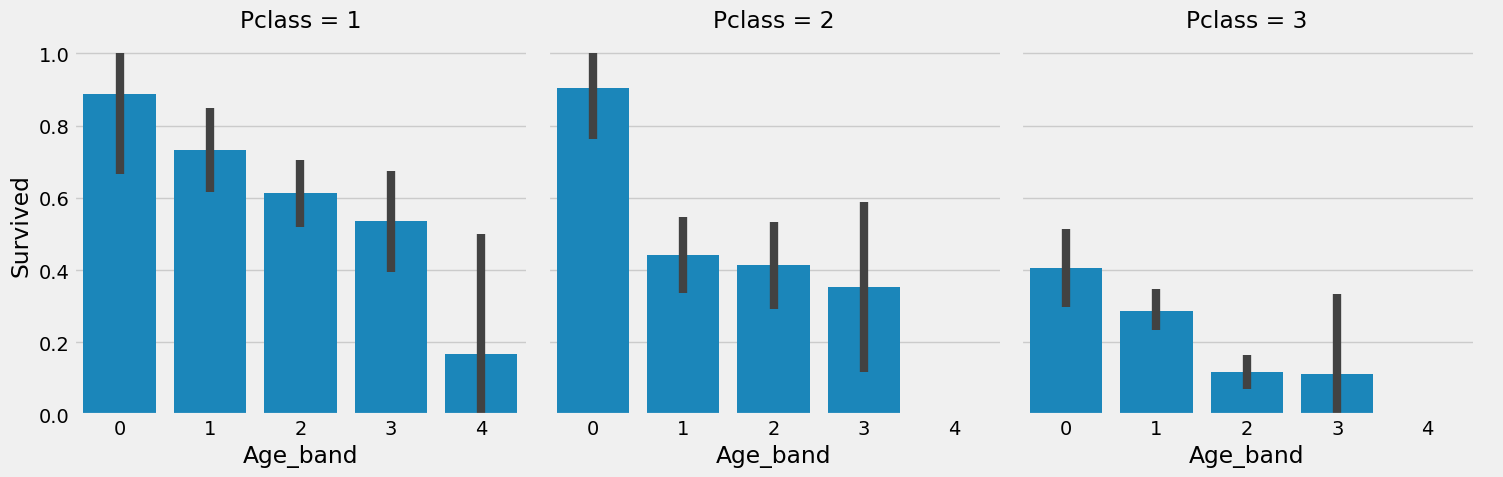

In [72]:
sns.catplot(x='Age_band',y='Survived',data=data,kind='bar',col='Pclass')
plt.show()

위 그래프 분석결과 나이가 증가함에 따라 생존율은 Pclass와 상관없이 감소하는 것을 확인했습니다

## 가족 크기와 혼자 여부
이 시점에서 "Family_size"와 "Alone"이라는 새로운 특성을 만들고 분석할 수 있습니다. 이 특성은 Parch와 SibSp의 합입니다. 이를 통해 승객의 가족 규모가 생존율과 관련이 있는지 확인할 수 있습니다. Alone은 승객이 혼자인지 여부를 나타냅니다.

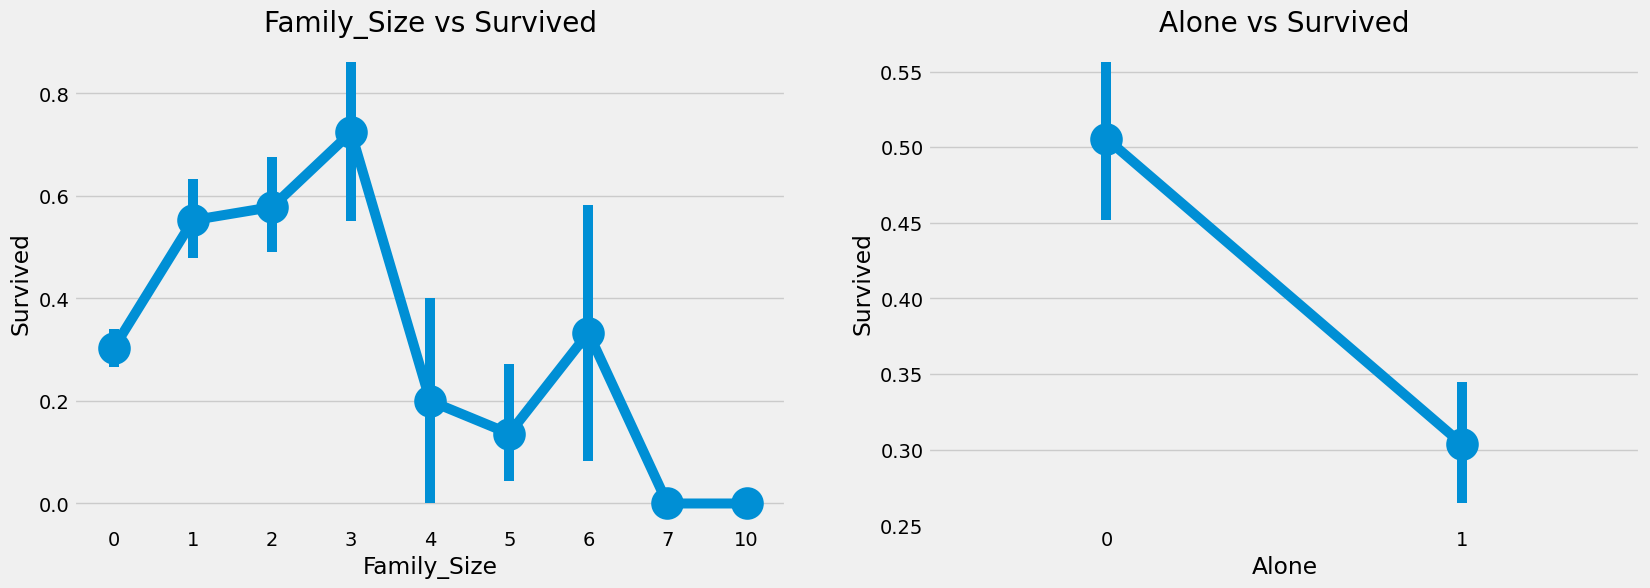

In [73]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.pointplot(x='Family_Size',y='Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.pointplot(x='Alone',y='Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

**Family_Size=0은 승객이 혼자인 것을 의미합니다.** 분명히, 혼자인 경우 또는 가족 규모가 0인 경우 생존 가능성이 매우 낮습니다. 가족 규모가 4보다 큰 경우에도 생존 가능성이 감소합니다. 이 또한 모델에 중요한 특성으로 보입니다. 이를 더 자세히 살펴보겠습니다.

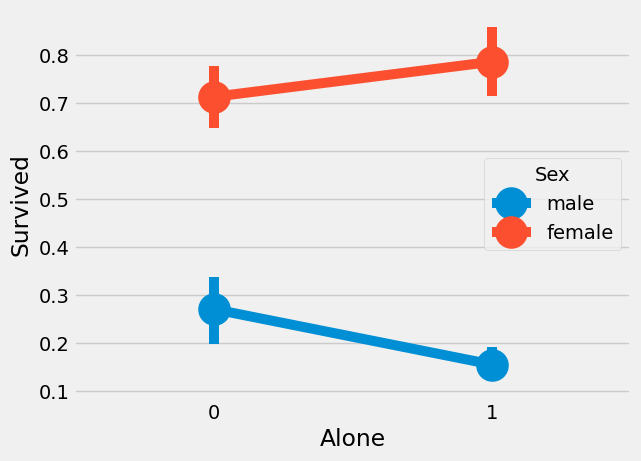

In [74]:
sns.pointplot(x='Alone', y='Survived', hue='Sex', data=data)
plt.show()

성별이나 Pclass와 관계없이 혼자 있는 것이 해로운 것으로 보입니다. 단, Pclass3의 경우 가족이 있는 여성들보다 혼자 있는 여성들의 생존 가능성이 더 높은 것으로 나타납니다.

## 운임 범위

운임도 연속적인 특성이므로 순위 값으로 변환해야 합니다. 이를 위해 **pandas.qcut**을 사용할 것입니다.

**qcut**이 하는 일은 전달한 bin 수에 따라 값을 분할하거나 정렬하는 것입니다. 예를 들어 5 개의 bin을 전달하면 값들이 동일한 간격으로 5 개의 별도 bin이나 값 범위로 정렬됩니다.

In [75]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


위에서 설명한대로, **운임 범위가 증가할수록 생존 가능성이 증가**하는 것을 명확히 볼 수 있습니다.

이제 우리는 Fare_Range 값을 그대로 전달할 수 없습니다. **Age_Band**와 동일하게 싱글톤 값으로 변환해야 합니다.

In [76]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

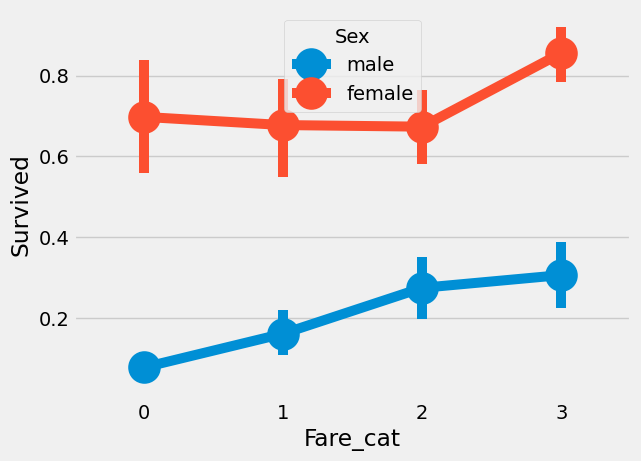

In [77]:
sns.pointplot(x='Fare_cat',y='Survived',hue='Sex',data=data)
plt.show()

명확히 Fare_cat이 증가함에 따라 생존 가능성이 증가합니다. 이 기능은 Sex와 함께 모델링 중에 중요한 기능이 될 수 있습니다.

## 문자열 값을 숫자로 변환

머신러닝 모델에 문자열을 전달할 수 없으므로, Sex, Embarked 등의 기능을 숫자 값으로 변환해야 합니다.

In [78]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

### 불필요한 특성 제거

**이름(Name)** --> 어떤 범주 값으로 변환될 수 없으므로 이 특성은 필요하지 않습니다.

**나이(Age)** --> 우리에게는 Age_band 특성이 있으므로 이 특성은 필요하지 않습니다.

**티켓(Ticket)** --> 범주화할 수 없는 임의의 문자열입니다.

**운임(Fare)** --> 우리에게는 Fare_cat 특성이 있으므로 필요하지 않습니다.

**객실(Cabin)** --> 많은 NaN 값이 있으며 많은 승객이 여러 개의 객실을 가지고 있습니다. 따라서 이 특성은 쓸모가 없습니다.

**운임 범위(Fare_Range)** --> Fare_cat 특성이 있습니다.

**승객 ID(PassengerId)** --> 범주화할 수 없습니다.

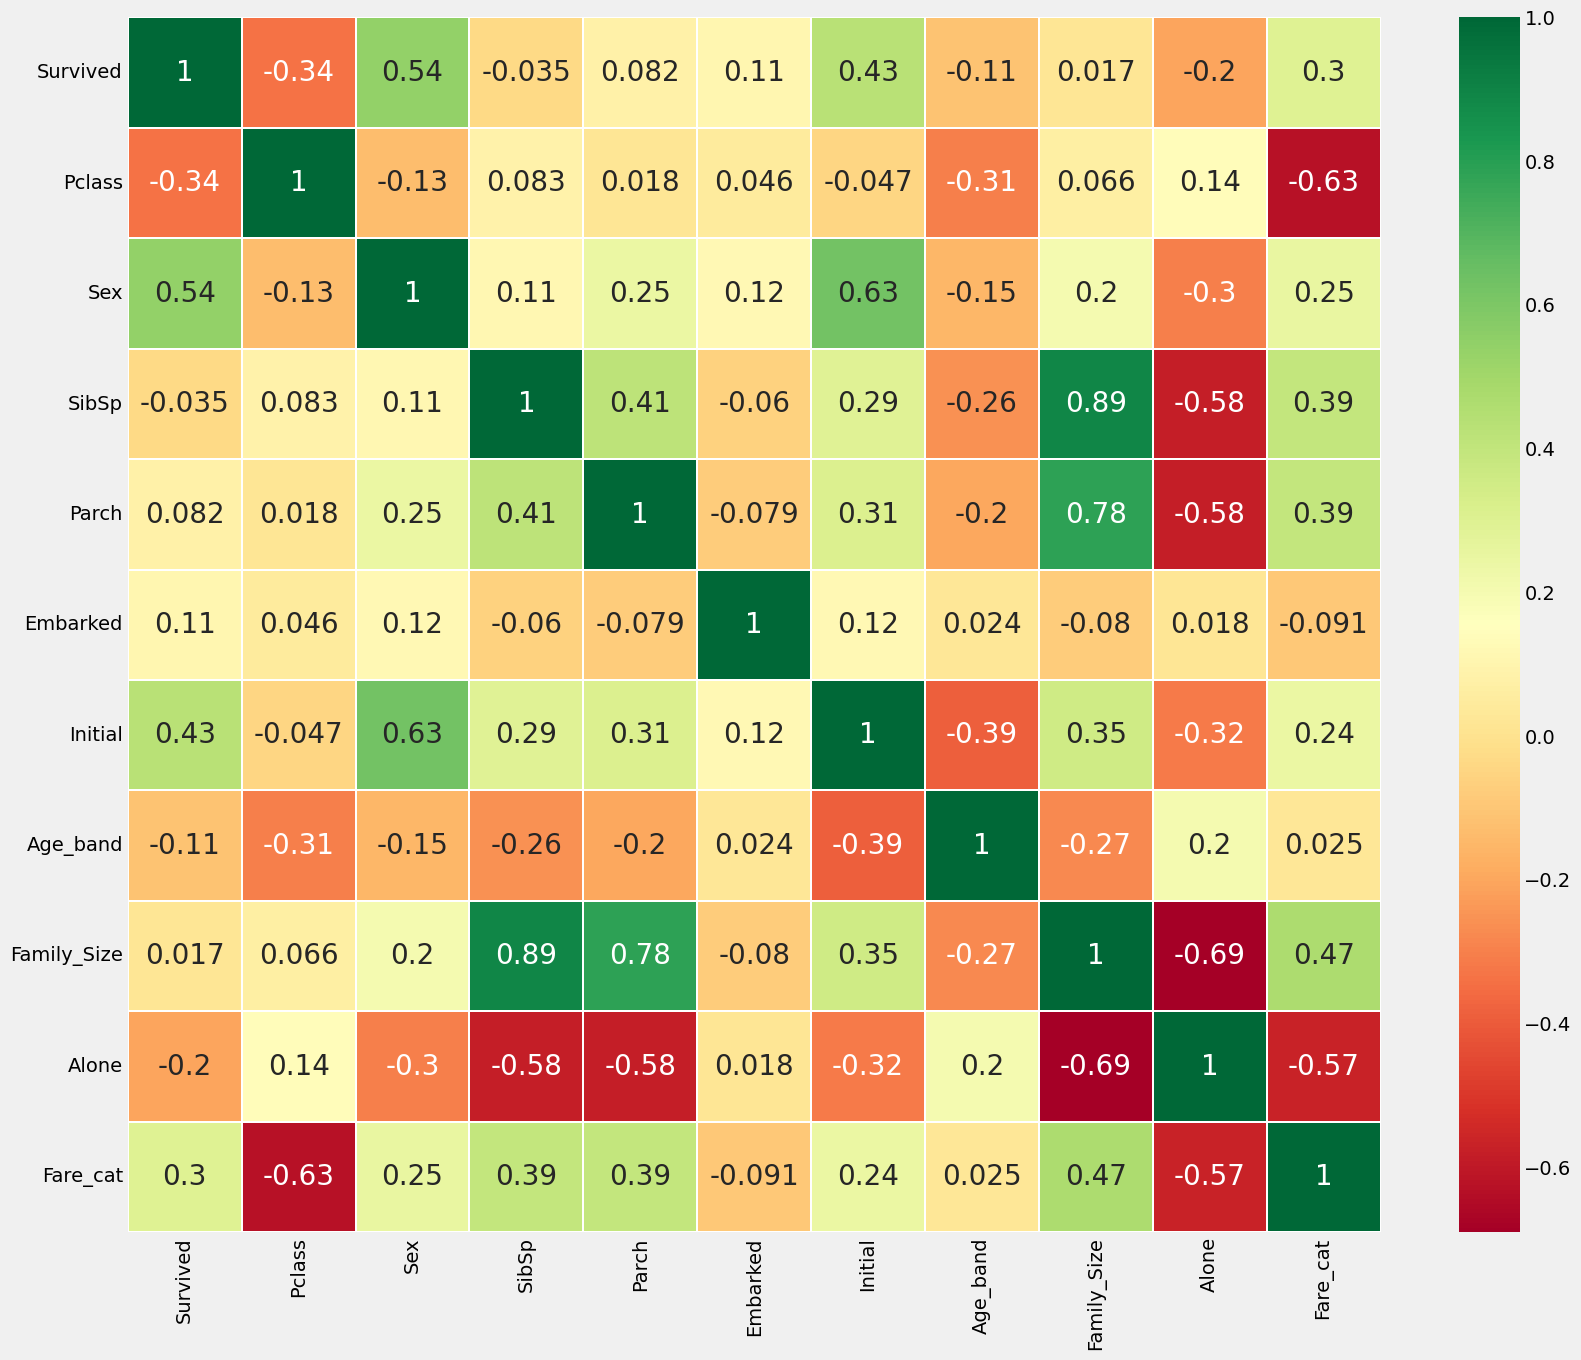

In [79]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

위의 상관 플롯에서 몇 가지 양의 관련된 특성을 볼 수 있습니다. 그 중 일부는 **SibSp와 Family_Size** 및 **Parch와 Family_Size**이며 **Family_Size와 Alone**와 같은 음의 관련성도 있습니다.

# Part3: 예측 모델링

EDA 부분에서 몇 가지 통찰력을 얻었습니다. 그러나 그것만으로는 승객이 생존할지 죽을지 정확하게 예측하거나 말할 수 없습니다. 그래서 이제 일부 우수한 분류 알고리즘을 사용하여 승객이 생존할지 여부를 예측하겠습니다. 다음은 모델을 만들기 위해 사용할 알고리즘입니다:

1) 로지스틱 회귀

2) 서포트 벡터 머신(선형 및 방사형)

3) 랜덤 포레스트

4) K-최근접 이웃

5) 나이브 베이즈

6) 의사 결정 트리

여기서 부터는 이러한 모델들을 이용해서 우리가 분석한 특징들을 가지고
데이터를 예측하는 머신러닝 모델을 만들어서 학습에 사용되지 않는 test 데이터를 이용해
머신러닝 모델의 성능을 평가해보자

In [80]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [81]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

### Radial Support Vector Machines(rbf-SVM)

In [82]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


### Linear Support Vector Machine(linear-SVM)

In [83]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


### Logistic Regression

In [84]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8134328358208955


### Decision Tree

In [85]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))


The accuracy of the Decision Tree is 0.8134328358208955


### K-Nearest Neighbours(KNN)

In [86]:
model=KNeighborsClassifier()
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.8134328358208955


KNN 모델의 정확도는 **n_neighbours** 속성의 값을 변경함에 따라 변경됩니다. 기본 값은 **5**입니다. **n_neighbours**의 다양한 값에 대한 정확도를 확인해 보겠습니다.

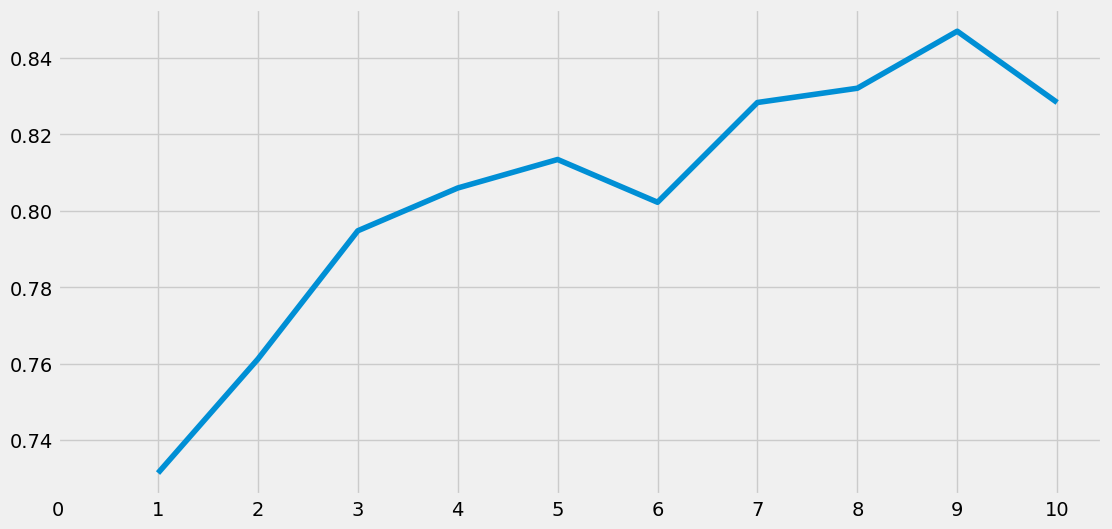

AttributeError: 'list' object has no attribute 'values'

In [90]:
a_index=list(range(1,11))
a=[]
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i)
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

### Gaussian Naive Bayes

In [91]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


### Random Forests

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

모델의 정확도는 분류기의 견고성을 결정하는 유일한 요소가 아닙니다. 예를 들어, 분류기가 훈련 데이터에서 훈련되고 테스트 데이터에서 테스트되어 정확도가 90%인 경우를 생각해보겠습니다.

이는 분류기에 대한 매우 좋은 정확도로 보일 수 있지만, 새로운 테스트 세트에 대해 항상 90%인지 확신할 수 있을까요? 그 답은 **아니오**입니다. 왜냐하면 분류기가 스스로 훈련에 사용할 인스턴스를 결정할 수 없기 때문입니다. 훈련 및 테스트 데이터가 변경됨에 따라 정확도도 변경됩니다. 이것을 **모델 분산**이라고 합니다.

이를 극복하고 일반화된 모델을 얻기 위해 **교차 검증**을 사용합니다.

# 교차 검증

데이터가 불균형 할 수 있습니다. 즉, 클래스1 인스턴스가 많지만 다른 클래스 인스턴스 수가 적을 수 있습니다. 따라서 데이터 집합의 각 인스턴스에서 알고리즘을 훈련하고 테스트해야 합니다. 그런 다음 데이터 집합 전체에 대한 모든 확인된 정확도를 평균화할 수 있습니다.

1) K-Fold Cross Validation은 먼저 데이터 집합을 k-부분 집합으로 나누는 것으로 작동합니다.

2) 데이터 집합을 (k=5) 부분으로 나눕니다. 1 부분을 테스트에 예약하고 알고리즘을 나머지 4 부분에 대해 훈련합니다.

3) 각 반복에서 테스트 부분을 변경하고 다른 부분에 대해 알고리즘을 훈련합니다. 그런 다음 정확도와 오류를 평균하여 알고리즘의 평균 정확도를 얻습니다.

이를 K-Fold Cross Validation이라고 합니다.

4) 알고리즘은 일부 훈련 데이터에 대해 데이터 집합에 대해 과소 적합할 수 있고 때로는 다른 훈련 세트에 대해 데이터에 대해 과적합할 수도 있습니다. 따라서 교차 검증을 통해 일반화된 모델을 얻을 수 있습니다.

In [ ]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10,shuffle=True, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
new_models_dataframe2

In [ ]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

In [ ]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

분류 정확도는 때로는 불균형으로 인해 오해를 일으킬 수 있습니다. 혼동 행렬을 사용하면 모델이 어디에서 잘못되었는지 또는 모델이 잘못 예측한 클래스를 확인할 수 있습니다.

## 혼동 행렬

분류기에 의해 수행된 올바른 및 부정확한 분류의 수를 보여줍니다.

In [ ]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

### Interpreting Confusion Matrix

### 혼동 행렬 해석

왼쪽 대각선은 각 클래스에 대한 올바른 예측 수를 보여주며 오른쪽 대각선은 잘못된 예측 수를 보여줍니다. 첫 번째 플롯을 rbf-SVM으로 고려해 봅시다:

1) 올바른 예측 수는 **죽은 사람 491명 + 생존한 사람 247명**이며 평균 CV 정확도는 **(491+247)/891 = 82.8%** 로 이전에 얻은 것과 일치합니다.

2) **오류** --> 58명의 죽은 사람을 생존으로 잘못 분류하고 95명의 생존자를 죽은 사람으로 잘못 분류했습니다. 따라서 이 모델은 생존한 사람을 죽은 것으로 잘못 예측하는 실수가 더 많았습니다.

모든 행렬을 살펴보면, rbf-SVM은 죽은 승객을 올바르게 예측할 가능성이 더 높지만 NaiveBayes는 생존한 승객을 올바르게 예측할 가능성이 더 높다고 말할 수 있습니다.

### 하이퍼파라미터 튜닝

머신러닝 모델은 마치 블랙 박스와 같습니다. 이 블랙 박스에는 기본 매개변수 값이 있습니다. 이 값을 조정하거나 변경하여 더 나은 모델을 얻을 수 있습니다. SVM 모델의 C 및 gamma와 같이 서로 다른 분류기에 대한 서로 다른 매개변수는 하이퍼파라미터라고 하며, 이를 조정하여 알고리즘의 학습 속도를 변경하고 더 나은 모델을 얻을 수 있습니다. 이를 하이퍼파라미터 튜닝이라고 합니다.

우리는 SVM과 랜덤 포레스트와 같은 두 가지 최상의 분류기의 하이퍼파라미터를 조정할 것입니다.

#### SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

#### Random Forests

In [ ]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Rbf-SVM의 최상의 점수는 C=0.05 및 gamma=0.1일 때 **82.82%**입니다. RandomForest의 경우, n_estimators=900일 때 약 **81.8%**의 점수를 얻습니다.

## Feature Importance

다양한 분류기(RandomForests, AdaBoost 등)의 중요한 특성을 살펴볼 수 있습니다.

#### 관찰:

1) 일부 공통 중요한 특성은 Initial, Fare_cat, Pclass, Family_Size입니다.

2) Sex 특성은 어떤 중요성도 부여되지 않는 것으로 보이며, 이는 Sex가 Pclass와 결합했을 때 매우 좋은 차별 요소였음을 고려하면 놀랍습니다. Sex는 RandomForests에서만 중요한 것으로 보입니다.

그러나 많은 분류기에서 상위에 위치한 Initial 특성을 볼 수 있습니다. Sex와 Initial 간의 양의 상관 관계를 이미 보았으므로 이들은 성별을 나타냅니다.

3) 마찬가지로 Pclass와 Fare_cat은 승객의 상태를 나타내며, Family_Size는 Alone, Parch 및 SibSp와 관련이 있습니다.